# Basic Error Rate

> 5/3/19

This document compares the "basic" error rates across different qubits. We will place each qubit into the 0 and 1 states and compare the error in an immediately subsequent measurement. This error rate should be some combination of preparation errors, gate errors (for the 1 state), and measurement error

In [2]:
# snippet: import quantum libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

We will measure the qubits in parallel for both the 0 and 1 cases. We will start with the 0 case.

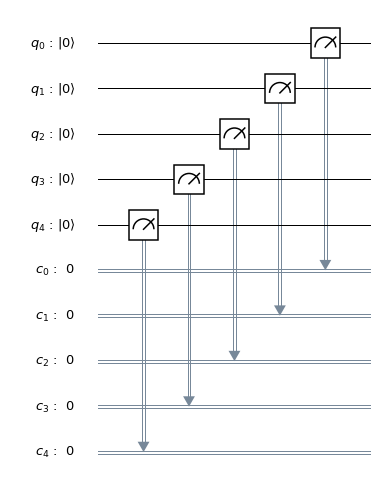

In [3]:
qr = q.QuantumRegister(5, 'q')
cr = q.ClassicalRegister(5, 'c')

circuit_0 = q.QuantumCircuit(qr, cr)
circuit_0.measure(qr, cr)
circuit_0.draw(output='mpl')

In [15]:
# snippet: wrapper to execute some circuit(s)
# this snippet depends on the quantum imports snippet
# parameters:
#   circuit: a single qiskit.QuantumCircuit or a list of them
#   shots, max_credits: self-explanatory
#   qubits: number of qubits needed (only necessary for auto-backend)
#   backend: either None (auto-choose leasy busy) or qiskit.IBMQBackend
#   opt: make circuit optimizations
# returns:
#   job: the job that ran
#   backend: the backend used
#   circuit: the circuit(s) used (for reproducibility)
def run(circuit, shots=1024, max_credits=10, qubits=5, backend=None, opt=True):

    if backend is None:
        # get least busy backend if not specified
        available = q.IBMQ.backends(filters=lambda x:
                                    x.configuration().n_qubits >= qubits
                                    and not
                                    x.configuration().simulator)
        backend = q.providers.ibmq.least_busy(available)

    manager = None
    if not opt:
        # disable optimization by adding a dummy pass manager
        manager = q.tools.compiler.PassManager()

    # execute job
    job = q.execute(circuit, backend=backend, shots=shots,
                    max_credits=max_credits, pass_manager=manager)
    monitor.job_monitor(job)

    # print job info for later retrieval if necessary
    print('Job ID \'%s\'' % job.job_id())
    print('Ran on backend \'%s\'' % backend.name())
    print('Completed %s' % job.creation_date())

    return job, backend, circuit

In [18]:
job_0, backend_0, _ = run(circuit_0)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5ccc88f61dbcd80074b71009'
Ran on backend 'ibmqx2'
Completed 2019-05-03T18:31:09.113Z


Next, we will try the 1 case.

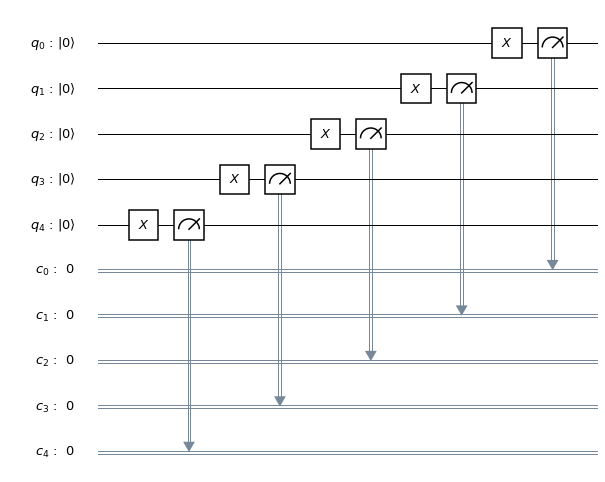

In [19]:
circuit_1 = q.QuantumCircuit(qr, cr)
circuit_1.x(qr)
circuit_1.measure(qr, cr)
circuit_1.draw(output='mpl')

In [26]:
# run with same backend for consistency
ibm = q.IBMQ.get_backend('ibmqx2')
job_1, backend_1, _ = run(circuit_1, backend=ibm)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5ccc8c608a0e3600776eacf0'
Ran on backend 'ibmqx2'
Completed 2019-05-03T18:45:52.474Z


Now we can make some pretty plots.

In [21]:
# snippet: retrieve an old qiskit job from job id and backend name
def get_job(job_id, backend_name):
    backend = q.IBMQ.get_backend(backend_name)
    return backend.retrieve_job(job_id)

In [28]:
job_0 = get_job('5ccc88f61dbcd80074b71009', 'ibmqx2')
job_1 = get_job('5ccc8c608a0e3600776eacf0', 'ibmqx2')

data_0 = job_0.result().get_counts(circuit_0)
data_1 = job_1.result().get_counts(circuit_1)

In [32]:
# analyze a trial and return the results as a tuple
def count_results(result, circuit, bit, shots=1024):
    freq   = [0, 0, 0, 0, 0]
    stderr = [0, 0, 0, 0, 0]

    for i in range(len(freq)):
        for state, count in result.items():
            if state[-i-1] == bit:
                freq[i] += count
        freq[i] /= shots
        stderr[i] = np.sqrt(freq[i] * (1 - freq[i]) / shots)    

    return freq, stderr

[0.9775390625, 0.6875, 0.99609375, 0.9990234375, 0.966796875]
[0.9267578125, 0.6767578125, 0.9267578125, 0.9677734375, 0.8515625]


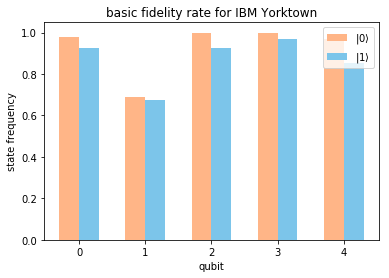

In [44]:
# plot fancy barplot
p0, s0 = count_results(data_0, circuit_0, '0')
p1, s1 = count_results(data_1, circuit_1, '1')
print(p0)
print(p1)

fig, ax = plt.subplots()
width = 0.3
qubits = np.arange(5)

ax.bar(qubits - width/2, p0, width, color='#ffb587', label=r'$\vert 0 \rangle$')
ax.bar(qubits + width/2, p1, width, color='#7cc5ea', label=r'$\vert 1 \rangle$')
ax.set_title('basic fidelity rate for IBM Yorktown')
ax.set_ylabel('state frequency')
ax.set_xlabel('qubit')
ax.legend()

Yet again, qubit 1 is acting up. Even the IBM calibration values have qubit 1 with a readout error an order of magnitude higher than all the other qubits. I think qubit 1 is going through a bit of a teenage rebellion phase.

Anyway, the blue bar is always lower than the orange bar; the difference is mostly due to the gate error for the NOT. Actually, we can do some statistics on what we would expect to measure based on the current IBM calibration values. We can do a chi-square test to see if the categories (measuring 0 and 1) occur with the expected frequency. At the time of writing (and executing), the current "official" error values are:

| Qubit | Q0 | Q1 | Q2 | Q3 | Q4
|---|---|---|---|---|---|
| Gate Error (10^-3) | 3.01 | 1.89 | 4.64 | 4.72 | 2.58 |
| Readout Error (10^-2) | 3.60 | 30.60 | 1.90 | 1.40 | 7.70 |